# RTED-TDS Co-Sim

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted`` has attributes ``rted`` and ``dcopf``. The two attributes are the RTED model and standard DCOPF model.
The two model can be built by methods ``build_rted()`` and ``build_dcopf()``, respectively. The results can be accessed by method ``get_res()``, after successfully solved the ``rted`` or ``dcopf``.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, amtplotlib, scipy

## Import case

In [1]:
import andes
import numpy as np
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table, make_GSF
andes.config_logger(stream_level=20)

import pandas as pd
import pandapower as pp
from math import ceil, floor

import os

import matplotlib.pyplot as plt

import scipy.stats as stat

from jams import rted2

Package version

In [2]:
print(andes.__version__)
print(pp.__version__)

1.6.5.post36.dev0+ga10e435b
2.8.0


Import ADNES case

In [3]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/case/ieee14_base.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)

Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes2"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee14_base.xlsx"...
Input file parsed in 0.0534 seconds.
System internal structure set up in 0.0224 seconds.


Set load as constant load.

In [4]:
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

Turn on ``numba`` can accelerate TDS.

In [5]:
ssa.config.numba

1

## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 2.237 p.u.


Text(0.5, 0, 'Time [s]')

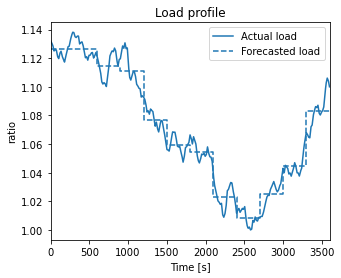

In [6]:
# --- get ANDES load ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale d_syn ---
ddata_path = '/case/d_syn2.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

ratio = 30
# The equation is tuned for ieee39
# original: (d_syn['h10'] - d_syn['h10'].mean()) / d_syn['h10'].var() * ratio + 1
d_syn['s10'] = ratio * (d_syn['h10'] - d_syn['h10'].min()) / d_syn['h10'].var() + 1

# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

fig_load, ax_load = plt.subplots(figsize=(5, 4))
ax_load.plot(d_syn['time'], d_syn['s10'], color='tab:blue', linestyle='-')
ystep = list(d_exp['s10'])
ystep.insert(0, d_exp['s10'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title('Load profile')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [7]:
# --- conversion ---
ssp = to_pandapower(ssa)

# add gen cost
gen_cost = np.array([
    [2, 0, 0, 3, 0.0, 40, 0],
    [2, 0, 0, 3, 0.0, 25, 0],
    [2, 0, 0, 3, 0.0, 30, 0],
    [2, 0, 0, 3, 0.0, 31, 0],
    [2, 0, 0, 3, 0.0, 32, 0],  # EV
    [2, 0, 0, 3, 0.0, 33, 0],  # Slack
])

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0951 seconds.
0: |F(x)| = 0.5605182162
1: |F(x)| = 0.006127943757
2: |F(x)| = 5.694809117e-06
3: |F(x)| = 5.725184216e-12
Converged in 4 iterations in 0.0055 seconds.
Power flow results are consistent. Conversion is successful.


True

**NOTE**: Alter the controllability of generator by modifying ``ssp.gen.controllable``

In [8]:
# set EV generator as uncontrollable
ssp.gen.controllable.iloc[4] = False

In [9]:
ssp.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,controllable,min_p_mw,max_p_mw,power_station_trafo
0,PV_2,1,40.000,1.03,100.0,-40.0,15.0,1.0,False,True,0.0,None,True,10.0,50.0,NaN
1,PV_3,2,40.000,1.01,100.0,-10.0,15.0,1.0,False,True,0.0,None,True,10.0,50.0,NaN
2,PV_4,5,30.000,1.03,100.0,-6.0,10.0,1.0,False,True,0.0,None,True,10.0,100.0,NaN
3,PV_5,7,30.000,1.03,100.0,-6.0,10.0,1.0,False,True,0.0,None,True,10.0,50.0,NaN
4,PV_6,3,-1.000,1.01,100.0,0.0,0.0,1.0,False,True,0.0,None,False,-10.0,10.0,NaN
5,Slack_1,0,81.442,1.03,100.0,-50.0,100.0,1.0,True,True,0.0,None,True,50.0,300.0,NaN


In [10]:
ssd = rted2()
ssd.from_andes(ssa)

# set EV as uncontrol for now
ssd.gen.ctrl.iloc[4] = 0
# set cost
ssd.cost.c1 = [40, 25, 30, 31, 32, 33]

ssd.build()
ssd.mdl.optimize()

Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0027 seconds.
0: |F(x)| = 0.5605182162
1: |F(x)| = 0.006127943757
2: |F(x)| = 5.694809117e-06
3: |F(x)| = 5.725184216e-12
Converged in 4 iterations in 0.0035 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0039 seconds.
0: |F(x)| = 0.5605182162
1: |F(x)| = 0.006127943757
2: |F(x)| = 5.694809117e-06
3: |F(x)| = 5

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 33 rows, 6 columns and 134 nonzeros
Model fingerprint: 0xe751f6cc
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 3e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 31 rows and 1 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2370000e+00   0.000000e+00   0.000000e+00      0s
       0    2.2370000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.237000000e+00


No RegUp cost data (``cru`` in ``cost``), set to 0.
No RegDn cost data(``crd`` in ``cost``), set to 0.
No RegUp requirement data (``du``), set to 0.
No RegDn requirement data (``dd``), set to 0.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 47 rows, 18 columns and 158 nonzeros
Model fingerprint: 0x1713409b
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [1e-01, 1e+02]
Presolve removed 45 rows and 14 columns
Presolve time: 0.00s
Presolved: 2 rows, 4 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2455000e+01   9.470000e-01   0.000000e+00      0s
       1    6.7237000e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.723700000e+01


In [11]:
ssd.get_res()

,gen,pg,pru,prd,bu,bd
0,PV_2,0.100,0.0,0.0,0.0,0.0
1,PV_3,0.500,0.0,0.0,0.0,0.0
2,PV_4,1.000,0.0,0.0,0.0,0.0
3,PV_5,0.147,0.0,0.0,0.0,0.0
4,PV_6,-0.010,0.0,0.0,0.0,0.0
5,Slack_1,0.500,0.0,0.0,0.0,0.0


In [12]:
pp.rundcopp(ssp)
ppres = ssp.res_gen
ppres['p_mw(GB)'] = ssd.mva * ssd.get_res()['pg']
print(f"pp cost={ssp.res_cost}")
ppres

pp cost=6723.700000074767


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,10.0,32.233505,-1.233634,1.0,10.0
1,50.0,13.328839,-1.952871,1.0,50.0
2,100.0,21.341148,1.644258,1.0,100.0
3,14.7,7.476212,-1.284473,1.0,14.7
4,-1.0,-1.176183,-2.574234,1.0,-1.0
5,50.0,-22.741468,0.000000,1.0,50.0


Def type 2 generator for EV

In [13]:
gen2 = ['PV_6']
prumax = [0]
prdmax = [0]
ssd.def_type2(gen2, prumax, prdmax)

## Prepare

### Make link table

In [14]:
# --- link_table ---
ssa_key = make_link_table(ssa)

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})
ssa_key2 = pd.merge(left=ssa_key,
                    right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                    on='stg_idx', how='left')

# --- device idx ---
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist()
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist()

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl * ssa_key2.stg_u.astype(bool)
ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,Slack_1,1.0,Slack_1,1,False,GENROU_1,ESST3A_2,TGOV1_1,BUS1,1.0,1.0,5,True
1,PV_2,1.0,PV_2,2,False,GENROU_2,EXST1_1,TGOV1_2,BUS2,1.0,1.0,0,True
2,PV_3,1.0,PV_3,3,False,GENROU_3,ESST3A_3,TGOV1_3,BUS3,1.0,1.0,1,True
3,PV_4,1.0,PV_4,6,False,GENROU_4,ESST3A_4,TGOV1_4,BUS6,1.0,1.0,2,True
4,PV_5,1.0,PV_5,8,False,GENROU_5,ESST3A_5,TGOV1_5,BUS8,1.0,1.0,3,True
5,PV_6,1.0,PV_6,4,EV_1,False,False,False,BUS4,0.5,0.5,4,False
6,PV_6,1.0,PV_6,4,EV_2,False,False,False,BUS4,0.5,0.5,4,False


### Define functions used in loop

In [15]:
# --- def functions ---
def get_pe(ssa, gov_idx, dg_idx, ssa_key2):
    """Get the active power (TurbineGov/DG) after TDS, a DataFrame"""
    # TODO: may need to sum the power of same StaticGen
    # --- TurbineGov --- 
    pe_syg = ssa.TurbineGov.get(src='pout', idx=gov_idx, attr='v')
    # --- DG ---
    Ip_dg = ssa.DG.get(src='Ipout_y', idx=dg_idx, attr='v')
    v_dg = ssa.DG.get(src='v', idx=dg_idx, attr='v')
    pe_dg = Ip_dg*v_dg
    # --- out ---
    pe = pd.DataFrame()
    pe['idx'] = gov_idx + dg_idx
    pe['pe'] = np.concatenate((pe_syg, pe_dg))
    ldf = pd.merge(left=ssa_key2.rename(columns={'dg_idx':'idx'}),
         right=pe, how='right', on='idx')
    rdf = pd.merge(left=ssa_key2.rename(columns={'gov_idx':'idx'}),
             right=pe, how='right', on='idx')
    pe['stg_idx'] = ldf['stg_idx'].fillna('') + rdf['stg_idx'].fillna('')
    return pe

def dp_calc(d_syn, idx_ed, intv_ed):
    """Calc SFR requirements, scalars, ``dpd_u``and ``dpd_d``, and load forecasted value ``load_exp``"""
    load = d_syn['s10'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)]
    load_exp = load.mean()
    # TODO: check if the estimation is reasonable
    load_ci = stat.t.interval(alpha=0.95, df=len(load)-1, loc=np.mean(load), scale=stat.sem(load))
    load_d = abs(load_ci[0] - load_exp)
    load_u = abs(load_ci[1] - load_exp)
    return load_u, load_d, load_exp

## Define param

In [16]:
# --- constants ---
t_total = 3600    # 3600s

intv_ed = 300  # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 100 # step change interval; smooth the setpoitns

n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0
agc_res = agc_table[['stg_idx']].copy()

# ACE vars
ACE_integral = 0
ACE_raw = 0
Kp = 0.05
Ki = 0.01
ace_res = pd.DataFrame()

# initial load
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [17]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw * 1

# store original generator data
ssp_gen0 = ssp.gen.copy()

for end_time in range(500): # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- Load update ---
        du, dd, load_exp = dp_calc(d_syn, idx_ed, intv_ed)
        ssp.load['p_mw'] = ssa_p0 * ssp.sn_mva * load_exp
        ssp.load['q_mvar'] = ssa_q0 * ssp.sn_mva * load_exp
        ssd.load['p0'] = ssa_p0 * load_exp
        ssd.update_dict()

        # --- RTED, update gen limits after SFR ---
        if end_time > 0:
            # get pe from TDS and sort
            pe_tds = get_pe(ssa, ssa_gov_idx, ssa_dg_idx, ssa_key2)
            pe_tds = pe_tds.merge(ssa_key2,
                                 on='stg_idx', how='right').groupby('stg_idx', as_index=False).sum()
            p_pre = pe_tds['pe'].tolist()
        else:
            # DCOPF results as the initial previous setpoints
            p_pre = list(ssp.res_gen.p_mw / ssp.sn_mva)

        # def sfr requirements and ev sfr limtis (p.u.)
        # TODO: Integrate EV; EV limits FROM EV; now set 0 to disable EV SFR
        ssd.def_sfr(du=du, dd=dd)

        # build and solve the RTED-DC
        ssd.build()
        res = ssd.mdl.optimize()

        dcres = ssd.get_res()  # get RTED-DC resutls
        # TODO: Integrate EV; send SFR back to EV

        # Reserve SFR and ramp from Generator limits in ``ssp``
        ssp_gen = pd.merge(left=ssp.gen.rename(columns={'name':'stg_idx'}),
                           right=dcres.rename(columns={'gen':'stg_idx'}),
                           on='stg_idx', how='left')
        # SFR limits
        ssp_gen['max_sfr'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['min_sfr'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva
        # ramp limits
        ssp_gen['max_ramp'] = ssp.sn_mva * (np.array(p_pre) + np.array(ssd.gen.ramp_agc))
        ssp_gen['min_ramp'] = ssp.sn_mva * (np.array(p_pre) - np.array(ssd.gen.ramp_agc))
        # alter generator limits
        ssp.gen.max_p_mw = ssp_gen[['max_sfr','max_ramp']].min(axis=1)
        ssp.gen.min_p_mw = ssp_gen[['min_sfr','min_ramp']].max(axis=1)

        # --- ACOPF, update setpoints ---
        # store setpoints
        if end_time > 0:
            p0 = ssp_res['p'].values  # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # run ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True) # Fill NA wil False

        # reset Generator limtis
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

    # --- interval AGC ---
    ace_gain = 1
    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # --- AGC allocation, with a power cap ---
        ACE_input = min(ACE_raw, dcres.pru.sum())
        if ACE_raw >= 0:
            ACE_input = min(ACE_raw, dcres.pru.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bu.values
        else:
            ACE_input = max(ACE_raw, -1 * dcres.prd.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bd.values
        agc_res[f'{end_time}'] = agc_table['paux']
        ace_data = [end_time, ACE_raw, dcres.pru.sum(),
                    -1*dcres.prd.sum(), ACE_input]
        ace_new = pd.DataFrame([ace_data], columns=['time', 'ace', 'up', 'dn', 'in'])
        ace_res = pd.concat([ace_res, ace_new])

        # --- Do AGC ---
        # a.SynGen
        agc_syg = pd.merge(left=agc_table,
                           right=ssa_key2,
                           on='stg_idx', how='right')
        agc_syg['paux2'] = agc_syg.paux * agc_syg.gammap
        cond_gov = agc_syg.ctrl * agc_syg.gov_idx.astype(bool)
        agc_gov = agc_syg.gov_idx[cond_gov].tolist()
        ssa.TurbineGov.set(src='paux0', idx=agc_gov, attr='v',
                           value=agc_syg.paux2.values)
        # b.DG
        agc_dg = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_dg['paux2'] = agc_dg.paux * agc_dg.gammap
        cond_dg = agc_dg.ctrl * agc_dg.dg_idx.astype(bool)
        agc_dg_idx = agc_dg.dg_idx[cond_dg].tolist()
        ssa.DG.set(src='pext0', idx=agc_dg_idx, attr='v',
                           value=agc_dg.paux2.values)
        
        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            if idx_agc == 0:
                # only record the pe from TDS in the first AGC interval
                copy = ssp_res.merge(right=pe_tds[['pe', 'stg_idx']], on='stg_idx', how='left')
                ssp_res['pe_tds'] = copy.pe
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            ssp_res['pref_step'] = ssp_res.p - ssp_res.pe_tds
            # smooth change threshold: 0.1
            large_index = ssp_res['pref_step'][abs(ssp_res['pref_step']) > 0.1].index
            ssp_res['pref_delta'] = ssp_res['pref_step']
            ssp_res['pref_delta'].iloc[large_index] = ssp_res['pref_step'].iloc[large_index] / n_step * idx_step
            ssp_res['pref'] = ssp_res.pe_tds + ssp_res.pref_delta
        # update SynGen setpoints
        cond_gov = ssp_res.controllable * ssp_res.gov_idx.astype(bool)
        ssa.TurbineGov.set(src='pref0', idx=ssp_res.gov_idx[cond_gov].tolist(),
                           attr='v', value=ssp_res.pref[cond_gov].values)
        # update DG setpoints
        cond_dg = ssp_res.controllable * ssp_res.dg_idx.astype(bool)
        ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[cond_dg].tolist(),
                   attr='v', value=ssp_res.pref[cond_dg].values)

    # --- intv_pq: alter load, run TDS ---
    if end_time == 0:
        # Initially, alter StaticGen: p0 and q0, RUN power flow
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        ssa.StaticGen.set(src='p0', idx=stg_opf_idx, attr='v', value=stg_opf_val)
        ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['s10'].iloc[end_time])
        ssa.PFlow.run()
    else:
        # Otherwise, alter Ppf and Qpf
        ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                    value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                    value=ssa_q0 * d_syn['s10'].iloc[end_time])

    # RUN TDS
    ssa.TDS.config.tf = end_time
    ssa.TDS.run()
    # ACE calculation
    ACE_integral = ACE_integral + ssa.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ssa.ACEc.ace.v.sum() + Ki*ACE_integral)

    # ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {end_time}s.")

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61 rows, 18 columns and 182 nonzeros
Model fingerprint: 0xc9f64861
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [6e-04, 1e+02]
Presolve removed 54 rows and 9 columns
Presolve time: 0.00s
Presolved: 7 rows, 9 columns, 21 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.9516991e+01   1.230116e+00   0.000000e+00      0s
       2    7.5993869e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.599386890e+01


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0027 seconds.
0: |F(x)| = 0.5704400569
1: |F(x)| = 0.03401556624
2: |F(x)| = 5.808623651e-05
3: |F(x)| = 1.753582696e-10
Converged in 4 iterations in 0.0036 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-0 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Numba compilation initiated with caching.
Initialization for dynamics completed in 0.2170 seconds.
Initialization was successful.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0011 seconds.
TimeSeries does not contain any time stamp.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

Current step size is zero. Integration is not permitted.
Simulation completed in 0.0548 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0539 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0601 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0539 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0462 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0605 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0454 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0496 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0438 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0504 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0411 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0415 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0522 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0440 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0416 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0453 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0426 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0415 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0405 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0439 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0492 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0546 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0438 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0427 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0474 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0481 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0520 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0492 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0515 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0526 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0532 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0536 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0518 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0453 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0440 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0459 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0448 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0453 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0448 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0440 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0428 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0448 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0412 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0485 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0431 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0428 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0438 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0428 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0425 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0425 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0462 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0427 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0788 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0900 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0497 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0507 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0500 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0453 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0439 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0427 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0459 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0440 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0535 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0896 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0501 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0439 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0493 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0483 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0495 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0604 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0470 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0495 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0454 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0425 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0422 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0448 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0454 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0431 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0431 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0428 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0427 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0470 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0481 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0426 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0439 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0426 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0583 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0511 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0492 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0489 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0570 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0566 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0572 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0438 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0877 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0569 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0547 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0618 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0553 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0493 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0470 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0425 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0508 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0484 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0515 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0526 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0521 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0480 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0595 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1383 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0524 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0547 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0618 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0478 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0459 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0415 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0398 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0448 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0422 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0504 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0440 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0399 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0412 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0405 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0411 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0453 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0422 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0427 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0412 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0412 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0415 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0403 seconds.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61 rows, 18 columns and 182 nonzeros
Model fingerprint: 0x682c75bc
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [7e-04, 1e+02]
Presolve removed 54 rows and 9 columns
Presolve time: 0.00s
Presolved: 7 rows, 9 columns, 21 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.9538360e+01   1.230996e+00   0.000000e+00      0s
       2    7.6020367e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.602036652e+01


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0397 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0425 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0426 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0398 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0408 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0426 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0399 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0399 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0561 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0539 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0439 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0411 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0422 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0417 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0422 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0412 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0412 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0416 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0608 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0395 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0400 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0598 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0417 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0416 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0415 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0395 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0400 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0426 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0399 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0425 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0426 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0417 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0425 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0393 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0415 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0403 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0394 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0396 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0406 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0416 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0403 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0397 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0408 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0405 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0411 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0399 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0406 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0414 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0425 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0416 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0409 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0402 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0417 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0415 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0408 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0411 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0396 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0406 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0405 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0397 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0622 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0495 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0412 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0408 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0411 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0416 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0427 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0403 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0406 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0414 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0402 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0410 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0411 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0581 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0426 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0417 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0417 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0411 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0416 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0436 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0427 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0414 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0508 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0442 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0619 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0411 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0531 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0493 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0419 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0633 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1548 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0601 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0549 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1022 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0562 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0518 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0578 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0523 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0454 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0409 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0560 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0617 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0493 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0410 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0427 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0503 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0532 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0488 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0405 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0422 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_79617/1054684377.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0485 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0428 seconds.


[Text(0.5, 51.00000000000006, 'Deviation [p.u.]'), Text(761.8, 0.5, '')]

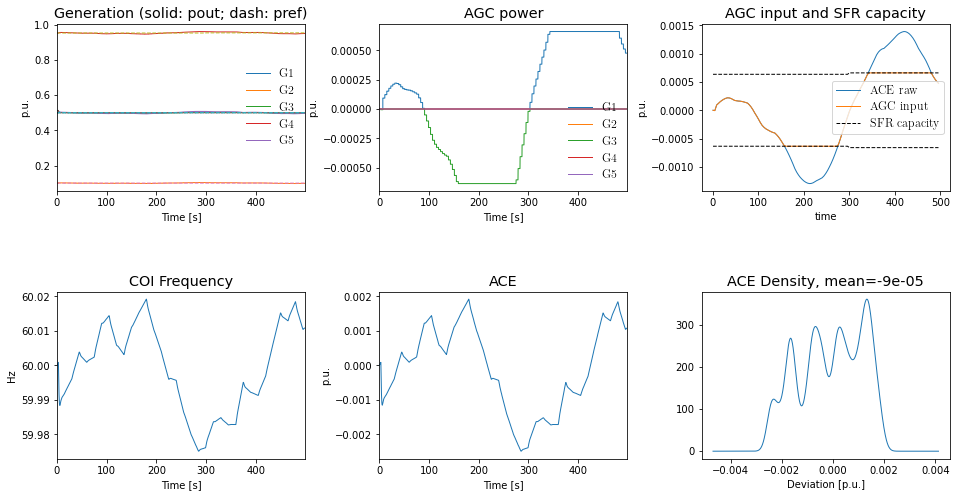

In [18]:
# color=['tab:blue', 'tab:orange', 'tab:green',
#        'tab:red', 'tab:purple']
right=end_time

fig_gen, ax_gen = plt.subplots(2,3, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.3, hspace=0.6)

yheader = [f'G{i}' for i in range(1,11)]

ssa.TDS.plt.plot(ssa.GENROU.Pe,
                 linestyles=['-'],
                   yheader=yheader,
                   legend=True, show=False, right=right,
                   title=r'Generation (solid: pout; dash: pref)',
                   ylabel='p.u.',
                   fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref,
                 legend=False, show=False, right=right,
                   linestyles=['--'],
                   fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                linestyles=['-'],
                yheader=yheader,
                legend=True, show=False, right=right,
                title=r'AGC power',
                ylabel='p.u.',
                fig=fig_gen, ax=ax_gen[0, 1])

ace_res.plot(linewidth=1,
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='ace',
            title=f'AGC input and SFR capacity')
ace_res.plot(linewidth=1,
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='in',)
ace_res.plot(linewidth=1, color='k', linestyle='--',
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='up')
ace_res.plot(linewidth=1, color='k', linestyle='--',
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='dn')
ax_gen[0, 2].set_ylabel('p.u.')
ax_gen[0, 2].legend(['ACE raw', 'AGC input', 'SFR capacity'])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 ytimes=60,
                 title=r'COI Frequency',
                 ylabel='Hz',
                 fig=fig_gen, ax=ax_gen[1, 0])

ssa.TDS.plt.plot(ssa.ACEc.ace,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 title=r'ACE',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[1, 1])


font = {'family' : 'TimesNewRoma',
        'weight' : '1',
        'size'   : 12}

plt.rc('font', **font)

ace_tds = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy()
ace_df = pd.DataFrame()
ace_df['ace'] = ace_tds
ace_df.plot(kind='kde', legend=False, linewidth=1,
            fig=fig_gen, ax=ax_gen[1, 2],
            title=f'ACE Density, mean={ace_df.ace.mean().round(5)}')
ax_gen[1, 2].set(xlabel='Deviation [p.u.]', ylabel='')